In [2]:
using SparseArrays
using LinearAlgebra
using Arpack
using Statistics
using Random
using DelimitedFiles
using NPZ
using ExpmV

In [3]:
function Hamiltonian(L)
    # Define Pauli matrices as complex sparse matrices
    id = sparse(ComplexF64[1 0 0; 0 1 0; 0 0 1])
    sx = 1/sqrt(2) * sparse(ComplexF64[0 1 0; 1 0 1; 0 1 0])
    sy = 1/sqrt(2) * sparse(ComplexF64[0 -im 0; im 0 -im; 0 im 0])
    sz = sparse(ComplexF64[1 0 0; 0 0 0; 0 0 -1])

    sp = 1/sqrt(2) * (sx + im * sy)
    sm = 1/sqrt(2) * (sx - im * sy)

    # Preallocate vectors of operators with correct type
    #sx_list = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L)
    #sy_list = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L)
    szl = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sz operators
    sz2l = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sz² operators
    spl = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sp operators
    sml = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sm operators

    for i_site in 1:L
        p_ops = fill(id, L)
        m_ops = fill(id, L)
        z_ops = fill(id, L)
        z2_ops = fill(id, L)
        p_ops[i_site] = sp
        m_ops[i_site] = sm
        z_ops[i_site] = sz
        z2_ops[i_site] = sz^2

        # Build the full operator by tensoring
        P = p_ops[1]
        M = m_ops[1]
        Z = z_ops[1]
        Z2 = z2_ops[1]
        for j in 2:L
            P = kron(P, p_ops[j])
            M = kron(M, m_ops[j])
            Z = kron(Z, z_ops[j])
            Z2 = kron(Z2, z2_ops[j])
        end

        spl[i_site] = P
        sml[i_site] = M
        szl[i_site] = Z
        sz2l[i_site] = Z2
    end

    dim = 3^L
    Ha = spzeros(ComplexF64, dim, dim)

    for i in 1:L
        ip = (i % L) + 1  # Periodic boundary
        Ha += ((spl[i]^2 * sml[ip]^2 + sml[i]^2 * spl[ip]^2) + adjoint((spl[i]^2 * sml[ip]^2 + sml[i]^2 * spl[ip]^2)))
    end

    Hb = spzeros(ComplexF64, dim, dim)

    for i in 1:L
        ip = (i % L) + 1  # Periodic boundary
        Hb += (spl[i] * szl[i] * sml[ip] * szl[ip] + sml[i] * szl[i] * spl[ip] * szl[ip] + adjoint(spl[i] * szl[i] * sml[ip] * szl[ip]) + adjoint(sml[i] * szl[i] * spl[ip] * szl[ip]))
    end

    Hc = spzeros(ComplexF64, dim, dim)

    for i in 1:L
        ip = (i % L) + 1  # Periodic boundary
        Hc += (spl[i]^2 * spl[ip] * szl[ip] + sml[i]^2 * sml[ip] * szl[ip] + adjoint(spl[i]^2 * spl[ip] * szl[ip]) + adjoint(sml[i]^2 * sml[ip] * szl[ip]))
    end

    return Ha, Hb, Hc, sz2l, szl 
end

Hamiltonian (generic function with 1 method)

In [17]:
Ha, _, _, _, _ = Hamiltonian(8)

(sparse([7, 4375, 4378, 3, 19, 20, 21, 4381, 16, 4384  …  2178, 6546, 2181, 6541, 6542, 6543, 6559, 2184, 2187, 6555], [3, 3, 6, 7, 7, 8, 9, 9, 12, 12  …  6550, 6550, 6553, 6553, 6554, 6555, 6555, 6556, 6559, 6559], ComplexF64[1.9999999999999982 + 0.0im, 1.9999999999999982 + 0.0im, 1.9999999999999982 + 0.0im, 1.9999999999999982 + 0.0im, 1.9999999999999982 + 0.0im, 1.9999999999999982 + 0.0im, 1.9999999999999982 + 0.0im, 1.9999999999999982 + 0.0im, 1.9999999999999982 + 0.0im, 1.9999999999999982 + 0.0im  …  1.9999999999999982 + 0.0im, 1.9999999999999982 + 0.0im, 1.9999999999999982 + 0.0im, 1.9999999999999982 + 0.0im, 1.9999999999999982 + 0.0im, 1.9999999999999982 + 0.0im, 1.9999999999999982 + 0.0im, 1.9999999999999982 + 0.0im, 1.9999999999999982 + 0.0im, 1.9999999999999982 + 0.0im], 6561, 6561), sparse([5, 2189, 3, 7, 2192, 5, 13, 14, 15, 2195  …  4367, 6547, 6548, 6549, 6557, 4370, 6555, 6559, 4373, 6557], [3, 3, 5, 5, 6, 7, 7, 8, 9, 9  …  6553, 6553, 6554, 6555, 6555, 6556, 6557, 6557, 

In [19]:
Ha

6561×6561 SparseMatrixCSC{ComplexF64, Int64} with 11664 stored entries:
⎡⠻⣦⡀⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⢬⠻⣦⡀⠀⠀⠀⠀⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠈⢻⣶⡀⢀⠀⠈⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⢈⡿⣯⣁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⢤⡀⠀⠁⠘⠻⢆⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠠⣄⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠉⠀⠀⠀⠀⠉⣱⣾⡁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠈⠿⣧⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⠀⠀⠀⠀⠀⠀⠀⠙⠦⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠻⣦⡗⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠉⠻⣦⡀⠀⠀⠀⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡰⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠐⠎⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⠀⠀⠀⠈⠻⣦⣀⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢼⠻⣦⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠲⣄⠀⠀⠀⠀⠀⠀⠀⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⢻⣶⡀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢈⡿⢏⣀⠀⠀⠀⠀⣀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠙⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠱⣦⡄⢀⠀⠈⠓⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢉⣻⣾⡁⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⡀⠀⠁⠈⠿⣧⡀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠀⠀⠀⠀⠈⠻⣦⡓⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠈⠻⣦⎦

In [23]:
using LinearAlgebra
using SparseArrays
using StatsBase
using Plots

"""
    level_spacing_statistics(H; nbins=50, range=(0,5))

Compute eigenvalues of a Hermitian Hamiltonian `H` (SparseMatrixCSC),
unfold the spectrum, and return normalized level spacing statistics.
"""
function level_spacing_statistics(H; nbins=25, range=(0,5))
    # Ensure Hermitian (drop small numerical asymmetries)
    H = Hermitian(Matrix(H))

    # Compute eigenvalues
    eigvals = eigen(H).values
    eigvals = sort(real.(eigvals))  # Ensure sorted, real spectrum

    # Compute spacings
    spacings = diff(eigvals)

    # Normalize (unfolding by mean spacing)
    spacings ./= mean(spacings)

    # Histogram (use nbins keyword!)
    hist = fit(Histogram, spacings; nbins=nbins, closed=:left)
    return spacings, hist
end

# Plot the histogram against Poisson and Wigner-Dyson distributions
function plot_spacing_distribution(spacings, hist)
    xs = range(0, 5, length=200)

    # Theoretical distributions
    poisson = exp.(-xs)                          # Poisson (integrable)
    wigner = (π/2) .* xs .* exp.(-π/4 .* xs.^2)  # Wigner-Dyson (GOE)

    bar(hist.edges[1][1:end-1], hist.weights ./ sum(hist.weights),
        width=step(hist.edges[1]), alpha=0.5, label="Data", legend=:topright)
    plot!(xs, poisson .* step(hist.edges[1]), lw=2, label="Poisson")
    plot!(xs, wigner .* step(hist.edges[1]), lw=2, label="Wigner-Dyson")
end


plot_spacing_distribution (generic function with 1 method)

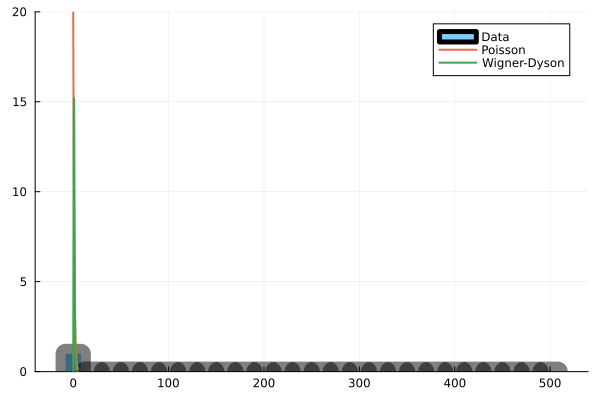

In [24]:
# Example Hamiltonian: random Hermitian matrix
using Random
Random.seed!(0)
N = 10
H = Ha  # make Hermitian

spacings, hist = level_spacing_statistics(H)
plot_spacing_distribution(spacings, hist)